In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 畳み込みニューラルネットワーク（CNN）とは

- 全結合ニューラルネットワーク 「Affine - ReLU」
>1. Affineレイヤ（**全結合層**）
>2. 隣接する全てのニューロン間で結合がある（fully-connected）
>3. データの形に関わらず、1次元に変形するため、データ形状に関する、空間的な情報を生かすことができない。<br><br>
- CNN 「Convolution - ReLU - （Pooling）」
>1. Convolutionレイヤ（**畳み込み層**）、Poolingレイヤ（**プーリング層**）
>2. 出力層に近いところは「Affine - ReLU」、出力層は「Affine - Softmax」
>3. **画像**などの形状があるデータを正しく理解できる可能性がある

![](image/08_cnn.png)
上段：全結合層によるニューラルネットワーク、下段：CNNによるニューラルネットワーク

# 畳み込み層

畳み込み層の入出力データを**特徴マップ**（**feature map**）、入力データを**入力特徴マップ**（**input feature map**）、出力データを**出力特徴マップ**（**output feature map**）という

## 2次元畳み込み演算

Cocvolutionレイヤ（畳み込み層）では、画像処理のフィルター演算に相当する「**畳み込み演算**」を行う

![](image/08_convolution.png)
1. ウィンドウ（赤四角）内のそれぞれの場所で、フィルター（カーネル）の要素と入力の対応する要素を乗算
2. 和を求める（1と2をまとめて**積和演算**という）
3. ウィンドウを一定間隔でスライドさせ、同様に計算

### パディング・ストライド

ゼロパディング：主に出力サイズ調整のため、周囲を任意幅のピクセルの0で埋める<br>
ストライド：フィルタを適用する位置の間隔

![](image/08_padding-stride.png)
これは、パディング幅1、ストライド2の例。<br>
基本的に、出力データは進むにつれて小さくなっていくので、パディングによりサイズを大きくするなどする。

### サイズの関係

$$OH=\dfrac{H+2P-FH}{S}+1$$

$$OW=\dfrac{W+2P-FW}{S}+1$$

入力サイズ$(H,W)$　フィルターサイズ$(FH,FW)$　出力サイズ$(OH,OW)$　パディング$P$　ストライド$S$

$OH$、$OW$は自然数の値になるようにパディングやストライドを調整する必要がある。<br>
ディープラーニングの場合、自然数値を取らない時は、最も近い整数に丸めて先へ進む場合がある。

## 3次元畳み込み演算

![](image/08_3d-convolution.png)
チャンネル方向に特徴マップが増えた。ブロックで表すとわかりやすい。

### バッチ処理

![](image/08_batch-processing.png)
畳み込み演算でも、N個のデータをまとめて与えてバッチ処理ができる。CNNでは、4次元のデータが流れる。

# プーリング層

プーリングは、縦・横方向の空間を小さくする演算。<br>
対象領域から最大値をとるMaxプーリング、平均値をとるAverageプーリングなどがある。<br>
一般に、ウィンドウサイズとストライドは同じ値に設定する。
- **学習パラメータがない**（最大値もしくは平均値を取るだけなどの処理）
- **チャンネル数は変化しない**（チャンネルごとに独立して計算）
- **微小な位置変化にロバスト（頑健）**（入力値の小さなズレに対し、同じような結果を返す）

![](image/08_max-pooling.png)
ストライド3で３×３のMaxプーリング

# レイヤの実装

## `im2col`データ展開

- `im2col`はバッチも含めた4次元データを2次元に変換する。
- `Numpy`で`for`文を使うと処理が遅くなるため、フィルター（重み）にとって都合の良いように入力データ展開をする`im2col`を利用する。
- メモリを多く消費するが、線形代数ライブラリを有効活用できる。

![](image/08_im2col.png)

`im2col`によって変換した2次元データと、一列に展開した重みの行列計算をする。

In [2]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):

    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

また、レイヤの逆伝播の際には`im2col`の逆の操作が必要であるため、`col2im`を以下で実装する。

In [3]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):

    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## Convolutionレイヤ

In [4]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

**`reshape(xx, -1)`**
- 多次元配列の辻褄が合うようにまとまる

**`transpose()`**
- 0から始まるインデックスを指定すると、多次元配列の順番の軸を入れ替える

## Poolingレイヤ

![画像を表示できません。](image/08_im2col-reshape.png)
`im2col`でデータを展開し、展開した行列に対し、行ごとに最大値を求め、適切な形状に変形する。

In [5]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# CNNの実装

「Convolution - ReLU - Pooling - Affine - ReLU - Affine - Softmax」の構成のCNNを実装する。

In [11]:
import pickle
from collections import OrderedDict
from source.common01.layers import *
from source.common01.gradient import numerical_gradient


class SimpleConvNet:
    """
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="pickle/cnn_params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="pickle/cnn_params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.2998645313178936
=== epoch:1, train acc:0.117, test acc:0.165 ===
train loss:2.2980388353162806
train loss:2.2922844191931735
train loss:2.284460929955969
train loss:2.2701891768511953
train loss:2.274494583304696
train loss:2.2382389500646487
train loss:2.2328418317090604
train loss:2.244962082080329
train loss:2.170468518919479
train loss:2.1523984383122614
train loss:2.1683184409618765
train loss:2.076912060550911
train loss:2.047503326256887
train loss:1.9935953630708227
train loss:1.9801291063027735
train loss:1.8734957274912816
train loss:1.7652407946340198
train loss:1.6280684845448652
train loss:1.6810002095241847
train loss:1.5958539514008239
train loss:1.596866404592111
train loss:1.4948912048113254
train loss:1.294579427422219
train loss:1.2823307859757733
train loss:1.2454139338447066
train loss:1.263909249294536
train loss:1.0399375951043084
train loss:1.0160711646973688
train loss:0.9882513309420677
train loss:0.935081878776311
train loss:0.9015274053599956
t

train loss:0.14128850264111337
train loss:0.41144510230525294
train loss:0.1769497335921153
train loss:0.3718404516642825
train loss:0.19002296412414654
train loss:0.3562261374590143
train loss:0.238142998088318
train loss:0.2162933543398559
train loss:0.20070655847050156
train loss:0.21812318951460127
train loss:0.08964038783679971
train loss:0.22972384389826206
train loss:0.12055078832990876
train loss:0.2259040806261028
train loss:0.37949901330441677
train loss:0.20465393588855574
train loss:0.3329992389390914
train loss:0.16265478965644942
train loss:0.17825486677636676
train loss:0.19907855454776757
train loss:0.31081276708574695
train loss:0.16065864100021163
train loss:0.3048969322337976
train loss:0.16388525593672554
train loss:0.15900494091964867
train loss:0.24541791711915237
train loss:0.16072976572746167
train loss:0.1951588206538475
train loss:0.13518013489057462
train loss:0.1858051378637796
train loss:0.11134324876462261
train loss:0.32441690177156873
train loss:0.244075

train loss:0.08114050279315506
train loss:0.13400597331885022
train loss:0.08489874316525169
train loss:0.1248010988535752
train loss:0.140554243923285
train loss:0.084491677997728
train loss:0.16251957518978838
train loss:0.07361802960881708
train loss:0.09194647122678949
train loss:0.19733575086877816
train loss:0.16987841008814417
train loss:0.11621246345391036
train loss:0.05635801351413965
train loss:0.09426185200266801
train loss:0.12196133936212297
train loss:0.11612465939109116
train loss:0.14978371108865496
train loss:0.06989409906153198
train loss:0.09533175680640386
train loss:0.17693644806203024
train loss:0.08071076827524576
train loss:0.07284183275870648
train loss:0.10693019145865527
train loss:0.06884718051032904
train loss:0.243241990202375
train loss:0.10972836645453654
train loss:0.0948951668545456
train loss:0.16991564887052413
train loss:0.06298651225884046
train loss:0.12631813923252092
train loss:0.145451618638882
train loss:0.08364306214174504
train loss:0.15591

train loss:0.09135460860542906
train loss:0.05167821902579965
train loss:0.04162543190776862
train loss:0.13511780429767842
train loss:0.1217304834324841
train loss:0.03935935024843742
train loss:0.047411794450359715
train loss:0.027345348202458788
train loss:0.055636301589847156
train loss:0.08162320894165795
train loss:0.11893741850414137
train loss:0.08433262679348742
train loss:0.055645354541617814
train loss:0.22055997319755283
train loss:0.028533031145986345
train loss:0.06654794050557633
train loss:0.06696863960929648
train loss:0.08608376150926199
train loss:0.10004880388830932
train loss:0.0608279119800648
train loss:0.07646505153705244
train loss:0.03740676126369546
train loss:0.04674899367978511
train loss:0.06263104279662576
train loss:0.08594197289186248
train loss:0.1264935801773865
train loss:0.1275069460924908
train loss:0.07625952806445326
train loss:0.04332899367366573
train loss:0.09387954796170414
train loss:0.10044410142771039
train loss:0.10748039774593604
train l

train loss:0.0715262305286314
train loss:0.1680921040786505
train loss:0.049472695082044035
train loss:0.064930727688567
train loss:0.05025451299971477
train loss:0.03083560247806278
train loss:0.048514217617445655
train loss:0.03363383612345138
train loss:0.033631423279362575
train loss:0.08904456100306739
train loss:0.028707067210893243
train loss:0.08425933339849837
train loss:0.04210336467470795
train loss:0.022836789853302085
train loss:0.1740795008738422
train loss:0.19901180404455712
train loss:0.04664972760089557
train loss:0.0526772349634484
train loss:0.02622725852400441
train loss:0.019028228928557725
train loss:0.06378853941875576
train loss:0.060628104974255505
train loss:0.07369355472744153
train loss:0.01663002173042224
train loss:0.08598497107193002
train loss:0.19562456816826596
train loss:0.12033965208101918
train loss:0.08969361257814143
train loss:0.13002743186187982
train loss:0.05298593654011394
train loss:0.06224327344722589
train loss:0.039391551915252745
train 

train loss:0.02215506414530214
train loss:0.0513135855123864
train loss:0.05492272523909562
train loss:0.021951126318924274
train loss:0.08839888098689974
train loss:0.055589728763800646
train loss:0.047174977881841974
train loss:0.05487935461727582
train loss:0.0858024075921072
train loss:0.08349000514034705
train loss:0.03462326914457064
train loss:0.04071205273145859
train loss:0.03761907944502531
train loss:0.036071143968824666
train loss:0.022468850521086457
train loss:0.10321344907696231
train loss:0.021057910927503615
train loss:0.02499881585295908
train loss:0.018452084458925343
train loss:0.05053127565324595
train loss:0.07479369874328988
train loss:0.025367552367216564
train loss:0.06706679045657676
train loss:0.03591550102370218
train loss:0.03519950099522862
train loss:0.08163696500528735
train loss:0.028115660683011915
train loss:0.088775103566323
train loss:0.050376772782518266
train loss:0.062259848442191325
train loss:0.03220349210384268
train loss:0.038261735585671884


train loss:0.021154021281605172
train loss:0.06332277054796469
train loss:0.16923762439170612
train loss:0.022269792837689425
train loss:0.033660405660026343
train loss:0.04276108742029791
train loss:0.06756708505004935
train loss:0.04702436318005457
train loss:0.052557572295798556
train loss:0.0316169674704189
train loss:0.08440283750435187
train loss:0.030809803943712785
train loss:0.04373379343439125
train loss:0.0646635656852574
train loss:0.03068464614609094
train loss:0.060373376784641615
train loss:0.03655891739315129
train loss:0.008613981835485868
train loss:0.05946583008718617
train loss:0.08745137108471238
train loss:0.05120375629723159
train loss:0.0861930978530432
train loss:0.12217686371292422
train loss:0.017975474752510413
train loss:0.06744504743811805
train loss:0.03364447474471712
train loss:0.053169520698203486
train loss:0.022221740951800423
train loss:0.04207565623607356
train loss:0.07535780041821348
train loss:0.022293874169047826
train loss:0.06859320958545044


train loss:0.013864498871105994
train loss:0.00947775115471683
train loss:0.012400519562705577
train loss:0.06823642928347554
train loss:0.022642790790722008
train loss:0.07480228235041425
train loss:0.07287933284204028
train loss:0.009507569214835372
train loss:0.027894138766274904
train loss:0.06361087546759256
train loss:0.01739822684665764
train loss:0.06130763296100107
train loss:0.06333354320751373
train loss:0.03568218159100797
train loss:0.04366194605899334
train loss:0.15165180556806504
train loss:0.019664937998820332
train loss:0.02438727915874342
train loss:0.07459694502308874
train loss:0.04930515131048224
train loss:0.11797639109544868
train loss:0.0543597065749348
train loss:0.0077161347845895135
train loss:0.04933376226476504
train loss:0.0099406952706617
train loss:0.058205717513178434
train loss:0.02014384403082121
train loss:0.03223053446038484
train loss:0.12606136920017227
train loss:0.009468817821620713
train loss:0.09932383343197212
train loss:0.03881595501206408


train loss:0.022783480446968304
train loss:0.004458991845216255
train loss:0.02010179772430692
train loss:0.02724715062873944
train loss:0.0498628731353078
train loss:0.049021397464232466
train loss:0.024240245168333042
train loss:0.07963746518558429
train loss:0.028354263317769576
train loss:0.027056917142097646
train loss:0.061835992112118
train loss:0.007621823718679668
train loss:0.04819604899677725
train loss:0.14103266155363076
train loss:0.016562093398516064
train loss:0.061272504136808036
train loss:0.04737845463133909
train loss:0.008012144685935403
train loss:0.06924868882873585
train loss:0.024244496064352358
train loss:0.0694652113944347
train loss:0.006711703541551659
train loss:0.030249174330020136
train loss:0.005301146017787521
train loss:0.07225818274336342
train loss:0.03473866078391306
train loss:0.017273483718623403
train loss:0.028437982458044672
train loss:0.0294156601260854
train loss:0.027917433948370273
train loss:0.02462479634988871
train loss:0.02013331193787

train loss:0.014267634533693598
train loss:0.00727417796640861
train loss:0.020602368133847592
train loss:0.05564961795059297
train loss:0.021654849087704924
train loss:0.041367187184788046
train loss:0.026673505186748093
train loss:0.05860979661116824
train loss:0.01761473540916038
train loss:0.01923249378770716
train loss:0.00474009539750252
train loss:0.03298153835302739
train loss:0.0699005703110726
train loss:0.010022205732275458
train loss:0.015913983020198138
train loss:0.08585671647867969
train loss:0.02321753453960542
train loss:0.024167259121225956
train loss:0.014460241191651927
train loss:0.008229310957850818
train loss:0.13340634516282396
train loss:0.05689297744648011
train loss:0.03717767845188684
train loss:0.026639335050259914
train loss:0.026408854275708687
train loss:0.032184281470204024
=== epoch:5, train acc:0.988, test acc:0.987 ===
train loss:0.012948381162389035
train loss:0.04097038859391728
train loss:0.028129502248434014
train loss:0.03824360190670281
train l

train loss:0.05524064267212024
train loss:0.018344686207803006
train loss:0.0077154524645521826
train loss:0.02450000775404341
train loss:0.02952222077254099
train loss:0.00551206962341179
train loss:0.02050741325642579
train loss:0.03452851005434995
train loss:0.07497621642107534
train loss:0.053708048393774986
train loss:0.014004130512473754
train loss:0.03226393658906162
train loss:0.0947077289283081
train loss:0.003729130103625956
train loss:0.015311390647095285
train loss:0.04621640079219132
train loss:0.010468917671634081
train loss:0.12514210191809835
train loss:0.08662530927772231
train loss:0.0054460073087388705
train loss:0.004103714637330698
train loss:0.010876430956189075
train loss:0.013787893915687193
train loss:0.04068223068209751
train loss:0.07305127530104073
train loss:0.1370255143547711
train loss:0.024964056427945285
train loss:0.025035967082178257
train loss:0.025837154912274493
train loss:0.029487213202855883
train loss:0.01920379732689834
train loss:0.01665896710

train loss:0.01764594070545067
train loss:0.006071993624807206
train loss:0.019385608619892757
train loss:0.020678653632941767
train loss:0.02560679037741829
train loss:0.004233618012430503
train loss:0.020435312010702034
train loss:0.04194840617938217
train loss:0.022500926795893994
train loss:0.015573176236968744
train loss:0.009804514980640236
train loss:0.011674977382990018
train loss:0.00708865375993562
train loss:0.09218325722377
train loss:0.010822827665351935
train loss:0.056613728700825795
train loss:0.018109467837819918
train loss:0.02409124952259399
train loss:0.020599033868113525
train loss:0.041546809079189735
train loss:0.02261712278687483
train loss:0.007526101270713462
train loss:0.058806058016338696
train loss:0.007413102024062812
train loss:0.015470582196446168
train loss:0.01905424276605907
train loss:0.01709104222300622
train loss:0.011613752011665937
train loss:0.02906848167315629
train loss:0.01258319292902809
train loss:0.007683238919219747
train loss:0.021075245

train loss:0.018402486698163054
train loss:0.03207155612937723
train loss:0.018685670467837975
train loss:0.005733652507104811
train loss:0.033160185820507906
train loss:0.011247519822862808
train loss:0.012580312301512884
train loss:0.067161944425205
train loss:0.005109591993709504
train loss:0.021839005575991558
train loss:0.019474391550027136
train loss:0.06974767771782191
train loss:0.09004661503631078
train loss:0.022273852980852715
train loss:0.02069605736290111
train loss:0.03871902703114475
train loss:0.06334909036908841
train loss:0.16983273363870385
train loss:0.024827102130730708
train loss:0.04139083586911429
train loss:0.012514211011739827
train loss:0.025434012811040123
train loss:0.00504507504035255
train loss:0.0242885445459904
train loss:0.006015603981429163
train loss:0.021227076088601478
train loss:0.018655708131934245
train loss:0.10872666410230282
train loss:0.009791312780719182
train loss:0.03916663105328419
train loss:0.018512350561104892
train loss:0.02258294109

train loss:0.010290252178547335
train loss:0.006470134410046637
train loss:0.010114994229859436
train loss:0.006384157275563215
train loss:0.01886163241793398
train loss:0.005735943748917136
train loss:0.022022087163374168
train loss:0.03555974920575478
train loss:0.05350303683339157
train loss:0.0052829838881730375
train loss:0.004289488305671151
train loss:0.006687247153205481
train loss:0.0036930642730364977
train loss:0.03063323763685732
train loss:0.010526363167932387
train loss:0.0030321539345989374
train loss:0.012862716153765143
train loss:0.004378753634304335
train loss:0.05122454976110232
train loss:0.007186344242819954
train loss:0.03774906333237514
train loss:0.003765280189380864
train loss:0.01584641153099554
train loss:0.006401196505656816
train loss:0.0772928441112814
train loss:0.008131655028735143
train loss:0.012668283957125015
train loss:0.0013790364535519691
train loss:0.0119520872247629
train loss:0.021741899622359534
train loss:0.012438295293612043
train loss:0.01

train loss:0.016420573753789407
train loss:0.04587017759622752
train loss:0.025907699265470447
train loss:0.01824308672938227
train loss:0.019968495997982585
train loss:0.00955695240900857
train loss:0.030680384488521985
train loss:0.02089902387325201
train loss:0.03799864843037149
train loss:0.009395710485731299
train loss:0.0322821212311819
train loss:0.003904749697489776
train loss:0.0670667767341076
train loss:0.013021021819336835
train loss:0.04162541071909362
train loss:0.014326859222497278
train loss:0.06382921333565922
train loss:0.05158635411539098
train loss:0.037752472072021176
train loss:0.04140578868438441
train loss:0.010514030864501549
train loss:0.004913600077566443
train loss:0.011103084298596173
train loss:0.003260056417982579
train loss:0.0173112945639159
train loss:0.017918034301855953
train loss:0.004874705286281807
train loss:0.0035227822232258045
train loss:0.006774316901823951
train loss:0.01743582153950585
train loss:0.007935894797263098
train loss:0.0041041992

train loss:0.010113648202025744
train loss:0.00976715462132248
train loss:0.012693745542631132
train loss:0.00981589005474519
train loss:0.007231651269237662
train loss:0.011539182050286994
train loss:0.06580694628706875
train loss:0.028396374478040682
train loss:0.060868047626588366
train loss:0.008178243510289751
train loss:0.05681567053666907
train loss:0.017416029935104924
train loss:0.024867592727523702
train loss:0.015903542099173815
train loss:0.03489466147374169
train loss:0.005725333537799131
train loss:0.031158076598815844
train loss:0.04862486725053519
train loss:0.004526175531068263
train loss:0.014390812564869526
train loss:0.005391096532019395
train loss:0.004640991259366679
train loss:0.014605881676761339
train loss:0.015863792473336673
train loss:0.05863567712441318
train loss:0.014176730605523016
train loss:0.01075435140327033
train loss:0.0034112695633391876
train loss:0.024670343034362954
train loss:0.008797805268401328
train loss:0.004102971513899913
train loss:0.02

train loss:0.010661659718265276
train loss:0.04372257102055211
train loss:0.006773170547700167
train loss:0.012474979320776665
train loss:0.010294622020274691
train loss:0.008700681502146049
train loss:0.010006233086847753
train loss:0.008768486626981346
train loss:0.003948440449792484
train loss:0.007425805150486754
train loss:0.009172393569989466
train loss:0.00447149954747373
train loss:0.007756962799302355
=== epoch:8, train acc:0.99, test acc:0.986 ===
train loss:0.022470008220119717
train loss:0.01746510918871458
train loss:0.018716028300770685
train loss:0.004910646413981184
train loss:0.01306646769765947
train loss:0.006515135675197981
train loss:0.0027014324261400054
train loss:0.02416310441048461
train loss:0.0018059514457626085
train loss:0.0038557432327468873
train loss:0.0020926367251472007
train loss:0.020805181091221328
train loss:0.03369655169321903
train loss:0.02300259209942371
train loss:0.03751089289922349
train loss:0.017765260857083718
train loss:0.056038927278265

train loss:0.01295783299535254
train loss:0.02182270276878586
train loss:0.006152628046275458
train loss:0.017790942644841528
train loss:0.007723360689975122
train loss:0.008367976152984463
train loss:0.0076324885840002524
train loss:0.06452782036462583
train loss:0.006705373080339528
train loss:0.0024045220526029564
train loss:0.03083586051543316
train loss:0.004187144894868965
train loss:0.04019586568914191
train loss:0.04036249787082771
train loss:0.0013049073560577045
train loss:0.026264934846696314
train loss:0.007400986726721028
train loss:0.028026447831667002
train loss:0.06444307086507828
train loss:0.026120941448470027
train loss:0.0030101112038844356
train loss:0.019261701491913332
train loss:0.004870430520179536
train loss:0.02539398265463229
train loss:0.04157205025926901
train loss:0.017235522142173644
train loss:0.005837469051023685
train loss:0.01326303863361953
train loss:0.004461677514607336
train loss:0.01119417873615538
train loss:0.0012245361874901786
train loss:0.0

train loss:0.004024586781451193
train loss:0.0092994168516775
train loss:0.014672428318073985
train loss:0.030438760849302665
train loss:0.00800255884697589
train loss:0.07187169006769135
train loss:0.0306599620800421
train loss:0.001843722745903347
train loss:0.011358970970229185
train loss:0.029293854349588866
train loss:0.026912139343815703
train loss:0.014319793357790484
train loss:0.00945566772177669
train loss:0.011940776170785873
train loss:0.002053492549998477
train loss:0.0036155765046768135
train loss:0.03590898820166511
train loss:0.04957714605729833
train loss:0.0053092538418599575
train loss:0.016413687054518046
train loss:0.004056026319208569
train loss:0.004147121739105719
train loss:0.017930134622452555
train loss:0.01506955207174255
train loss:0.06718724291178191
train loss:0.012089540049575182
train loss:0.010260683605337773
train loss:0.006631606394748025
train loss:0.002078841604694009
train loss:0.0024881801764941643
train loss:0.00544647116374204
train loss:0.0223

train loss:0.005801635794712182
train loss:0.004951273487879331
train loss:0.0017524529225083412
train loss:0.012206400250118392
train loss:0.03384469327462032
train loss:0.02269159362344243
train loss:0.014020125562057395
train loss:0.017977016652619478
train loss:0.009369299101328088
train loss:0.0032826066223989665
train loss:0.0054795243104440935
train loss:0.00667343380020581
train loss:0.009398872872105512
train loss:0.011934216596247195
train loss:0.018072676904755378
train loss:0.008880966122056369
train loss:0.014015327291924813
train loss:0.0025553336363714776
train loss:0.004344990908876912
train loss:0.011942035777119685
train loss:0.0022893230435203265
train loss:0.025012392417271365
train loss:0.007618495793635679
train loss:0.005004834929196082
train loss:0.008608432132345363
train loss:0.00822268031172678
train loss:0.005287750474821221
train loss:0.014606205914592281
train loss:0.0007720556008776851
train loss:0.015444289464883396
train loss:0.0028300351655550482
train

train loss:0.005145895899329575
train loss:0.007787588190584319
train loss:0.008172914954366233
train loss:0.001764711239064085
train loss:0.006440253525901728
train loss:0.005253118400441856
train loss:0.017468459767878072
train loss:0.0011150369776558983
train loss:0.0038859153261243478
train loss:0.0030826590021967833
train loss:0.006126793048214848
train loss:0.014613607365922812
train loss:0.002009335761435854
train loss:0.005611253348083829
train loss:0.009139619578120243
train loss:0.01160158033916065
train loss:0.0015688142780318722
train loss:0.0047495922055285555
train loss:0.007948429777412565
train loss:0.005708321791762734
train loss:0.003845494356283059
train loss:0.010250131156442717
train loss:0.00342445768123053
train loss:0.0047988911255354445
train loss:0.0028331033357800574
train loss:0.0012667214810394866
train loss:0.0053070414657994565
train loss:0.0023380250293572402
train loss:0.0013051033956746623
train loss:0.003765047861565883
train loss:0.025890581218694076

train loss:0.00680870034476641
train loss:0.0032020096653623113
train loss:0.0041259148499207055
train loss:0.0006743006867250348
train loss:0.0012717393657240867
train loss:0.00822918673518219
train loss:0.011883157811059968
train loss:0.006046881749073572
train loss:0.004987954768842532
train loss:0.004348637492820036
train loss:0.0032042785011050434
train loss:0.009167297722027033
train loss:0.045553984220651274
train loss:0.0013483588040357018
train loss:0.01064086061973132
train loss:0.014735386701988732
train loss:0.0021518995651428215
train loss:0.02979230923608527
train loss:0.04912281701644919
train loss:0.005471441428852855
train loss:0.022339610198734886
train loss:0.03086391013342278
train loss:0.005976219272361204
train loss:0.004869200970536793
train loss:0.008446458173058401
train loss:0.012901603349143989
train loss:0.0014671096960869815
train loss:0.0035662481902018423
train loss:0.0468195006647026
train loss:0.026013573729220973
train loss:0.0012616977109589258
train 

train loss:0.003201363959420145
train loss:0.0033603032433760925
train loss:0.006841779156099475
train loss:0.006081738006939743
train loss:0.0024863245323815055
train loss:0.009912626241989858
train loss:0.00504644258997819
train loss:0.0052014619579855625
train loss:0.0027222680317628032
train loss:0.0021940654079183972
train loss:0.005058651562268971
train loss:0.012183969999432298
train loss:0.02091005235094092
train loss:0.002104131772150336
train loss:0.004334423587525413
train loss:0.004010970475359751
train loss:0.002550422398804647
train loss:0.004790274624254739
train loss:0.004748413053488441
train loss:0.011088264899830053
train loss:0.003453874350541455
train loss:0.0010918580678685905
train loss:0.0013575878567074543
train loss:0.014505965952318343
train loss:0.009773300799399197
train loss:0.005199865227222429
train loss:0.004140373214504515
train loss:0.0036231217291548806
train loss:0.017195879814006495
train loss:0.008732650852774583
train loss:0.006129510851431272
tr

train loss:0.0025257479299375905
train loss:0.006582830260546171
train loss:0.0027267045268127145
train loss:0.0067867745363298735
train loss:0.0014884190391811164
train loss:0.000708859229046017
train loss:0.0012305390636484026
train loss:0.0043522633790652795
train loss:0.002044411019781778
train loss:0.008881922124107556
train loss:0.02261966780449725
train loss:0.0005873488630561397
train loss:0.006568956031875683
train loss:0.08139651827225643
train loss:0.054035585341324494
train loss:0.009976600221381806
train loss:0.009740177860383665
train loss:0.0011199145066476983
train loss:0.004278148860299872
train loss:0.004202031842779413
train loss:0.005034527928515493
train loss:0.001581570850565677
=== epoch:11, train acc:0.994, test acc:0.99 ===
train loss:0.002793571472794838
train loss:0.004320653107282424
train loss:0.0023348229937515032
train loss:0.016381481784600506
train loss:0.004698117602862532
train loss:0.007039635396444141
train loss:0.00335883768197557
train loss:0.0146

train loss:0.0032586935516295003
train loss:0.013091411225720941
train loss:0.0172028317696406
train loss:0.0012990225444601078
train loss:0.007414687599438479
train loss:0.002314271562251934
train loss:0.003491913760926778
train loss:0.010862538611919857
train loss:0.003930936078419868
train loss:0.014692045756585035
train loss:0.012385432332706517
train loss:0.00019368894007827192
train loss:0.0071122442372115735
train loss:0.003641178738133
train loss:0.00501933136749545
train loss:0.0006381585456453982
train loss:0.02636996935988275
train loss:0.0032102835210036018
train loss:0.017180056594117275
train loss:0.01007997395889622
train loss:0.004207467801395841
train loss:0.009591313480302231
train loss:0.012498896563868999
train loss:0.01086586562201996
train loss:0.004244806957836212
train loss:0.0004226369987669729
train loss:0.005158102981512797
train loss:0.007590327633140911
train loss:0.0019398351724495369
train loss:0.0026077152785391865
train loss:0.017243670788496656
train l

train loss:0.0013514683908591458
train loss:0.0011265236432445405
train loss:0.006874904782552458
train loss:0.0012481184246911888
train loss:0.001002283883106156
train loss:0.018069552618945682
train loss:0.004073488424105161
train loss:0.0009801431446290823
train loss:0.0026512717619310354
train loss:0.0017449193003198004
train loss:0.0032026039664936647
train loss:0.0019718226731269615
train loss:0.0009923288189096137
train loss:0.0028144990371772025
train loss:0.0007650773480629659
train loss:0.0004168139025021335
train loss:0.0021850520348311434
train loss:0.004236877917473078
train loss:0.0064435936204058405
train loss:0.0001702157117090432
train loss:0.002997372018574136
train loss:0.0038620731509771337
train loss:0.004731745322670785
train loss:0.00371394538019616
train loss:0.00480749248569738
train loss:0.016846885774564595
train loss:0.003763154796269309
train loss:0.01466523495980932
train loss:0.00692985229361326
train loss:0.004465578295760248
train loss:0.000836957980907

train loss:0.0031905794017278903
train loss:0.0024564372995959263
train loss:0.0006351449984545752
train loss:0.015138653588381007
train loss:0.0025715620178871175
train loss:0.006034538036605902
train loss:0.00019597047702187627
train loss:0.016568972833393966
train loss:0.007177931547954831
train loss:0.004518831712549066
train loss:0.0038844418841758005
train loss:0.0014898859845153048
train loss:0.005057790937197753
train loss:0.032609483326557775
train loss:0.003792713474546587
train loss:0.0031777624262367414
train loss:0.0013275688398439436
train loss:0.003330065166581109
train loss:0.00034017530089354496
train loss:0.0008769459196782359
train loss:0.010543035074647138
train loss:0.005067376522343237
train loss:0.007311573567156142
train loss:0.002311440624864334
train loss:0.018276446536165298
train loss:0.0028678784524461503
train loss:0.001855890077326678
train loss:0.005989159418203915
train loss:0.008558819264435361
train loss:0.0026705128678035516
train loss:0.003343376991

train loss:0.002973106390942626
train loss:0.015429344277708845
train loss:0.01319243801699381
train loss:0.005313561390113286
train loss:0.006106277665508442
train loss:0.0045005640154557195
train loss:0.005383594651869506
train loss:0.018750870192800806
train loss:0.018901040928517698
train loss:0.005716794907724435
train loss:0.0037395817587461654
train loss:0.005327691874211868
train loss:0.002645457170248125
train loss:0.011378084969607245
train loss:0.004260851574144991
train loss:0.000325678761271442
train loss:0.00030039848048630277
train loss:0.002051858291974874
train loss:0.0008066975129179672
train loss:0.002046264411358221
train loss:0.0025068649537746414
train loss:0.012877223055429068
train loss:0.002815837038082483
train loss:0.00935502416019706
train loss:0.002788992406455724
train loss:0.014914145328979783
train loss:0.0001897282780682145
train loss:0.0004636116812584238
train loss:0.004971425644066597
train loss:0.0007709913465831606
train loss:0.0030983681681964765


train loss:0.0038317682672343984
train loss:0.01077192564431878
train loss:0.002516944759758858
train loss:0.009762113474384817
train loss:0.0010601829491487854
train loss:0.0011429959293969684
train loss:0.0018450627351404708
train loss:0.005364824398488466
train loss:0.004642203916129792
train loss:0.008608794501537745
train loss:0.0008075887152736577
train loss:0.0037048392113981305
train loss:0.017440211768476675
train loss:0.019120281627809457
train loss:0.00816463689614169
train loss:0.00031470210623464834
train loss:0.0007624703345803205
train loss:0.0032376295500297424
train loss:0.034021645101039326
train loss:0.003096194776597741
train loss:0.0019210283338265302
train loss:0.00046103348707962665
train loss:0.0004835694078636285
train loss:0.008537212598890214
train loss:0.0018706774125892835
train loss:0.0009669842761889424
train loss:0.004919525438211677
train loss:0.0005756021950384619
train loss:0.0022747761091407494
train loss:0.0011700310424849715
train loss:0.0037189772

train loss:0.0016499642113661998
train loss:0.002964537955401543
train loss:0.002448668183048641
train loss:0.003375411146177252
train loss:0.007115096608198883
train loss:0.0018110458371868587
train loss:0.010075956279651476
train loss:0.0002398384307253524
train loss:0.01318818226947571
train loss:0.001051439617762644
train loss:0.0053151399837373815
train loss:0.00039749802287625057
train loss:0.004606958182304005
train loss:0.0065977023349170815
train loss:0.0008625709198569596
train loss:0.0030229794573789414
train loss:0.0030228839707766987
train loss:0.0017364234862137793
train loss:0.002384835992162426
train loss:0.00495595633089386
train loss:0.0015158383696997804
train loss:0.0009612015812360265
train loss:0.002382585699036318
train loss:0.014482701177721042
train loss:0.0009531370668282559
train loss:0.0010382863064269637
train loss:0.0008093228069651201
train loss:0.019890058235429366
train loss:0.001739789088195082
train loss:0.016180873380590547
train loss:0.0082970087844

train loss:9.971703124109702e-05
train loss:0.0049518546165546
train loss:0.059409183112987624
train loss:0.0012267505379749725
train loss:0.0003515142857785422
train loss:0.004608261642826081
train loss:0.0024970412168779047
train loss:0.05371498447144792
train loss:0.01864144475384135
train loss:0.0066573533111069704
train loss:0.003007532278818412
train loss:0.03173610641826884
train loss:0.005121176563715438
train loss:0.00036529354074189976
train loss:0.0020987314158380723
train loss:0.0017631396223423315
train loss:0.05475729911036598
train loss:0.002737726440875255
train loss:0.0026048659293425327
train loss:0.002460590450687308
train loss:0.008005725239296366
train loss:0.0048088966598333
train loss:0.0010652677157889433
train loss:0.007257397481310014
train loss:0.007419083255547906
train loss:0.0008522983375261221
train loss:0.001587506590799274
train loss:0.002982661833270053
train loss:0.0013501666649184051
train loss:0.0028044478759233537
train loss:0.0007621949547713725
t

train loss:0.0006917286972536121
train loss:0.0035322201720765557
train loss:0.002269001744221183
train loss:0.0034553502813134004
train loss:0.0006382088719557899
train loss:0.001105517186642357
train loss:0.007493758418083456
train loss:0.000475242003572498
train loss:0.0009221760468490575
train loss:0.0024770923988222918
train loss:0.0008736603177797378
train loss:0.0033943659912120073
train loss:0.005588445277987169
train loss:0.0009264141202523517
train loss:0.003143523547594454
train loss:0.0009147743950358381
train loss:0.0029951137465189944
train loss:0.0009897314100091336
train loss:0.005533455716735679
train loss:0.011427433033847783
train loss:0.009155289803695475
train loss:0.01027142385716487
train loss:0.008759153158148968
train loss:0.002349051594265198
train loss:0.0067215570015580215
train loss:0.00016797465591794159
train loss:0.008166007083785927
train loss:0.004481793901599195
train loss:0.0010216426922707111
train loss:0.0010102812024460719
train loss:0.00235070886

train loss:0.001200766705437224
train loss:0.005546995834956369
train loss:0.0023094022121648208
train loss:0.004086544536547458
train loss:0.0025090828360932516
train loss:0.0019568598933966813
train loss:0.004318550406923424
train loss:0.03146029119130518
train loss:0.0007726979433255918
train loss:0.009563246441634705
train loss:0.01054836254491422
train loss:0.010480381613294652
train loss:0.003307207212300805
train loss:0.005341125320149212
train loss:0.0015543725327311396
train loss:0.007109472665027046
train loss:0.02867829992454316
train loss:0.010799009035307595
train loss:0.0027079243962032334
train loss:0.0012278069251214735
train loss:0.0010740744964884688
train loss:0.0025703207755071785
train loss:0.0015331762037053128
train loss:0.0014926371199447492
train loss:0.00026394420164287927
train loss:0.0026147635368931094
train loss:0.00026793239209622086
train loss:0.0008622978983813392
train loss:0.0006355513738663901
train loss:0.004676665503081397
train loss:0.004757025450

train loss:0.030129732885637427
train loss:0.0014280159325378591
train loss:0.001029165711434719
train loss:0.004956771427134871
train loss:0.006673888084600577
train loss:0.0017523876643116294
train loss:0.007683461253364981
train loss:0.0010646311505277685
train loss:0.001616952209685175
train loss:0.0004511885295500964
train loss:0.0011256866045488037
train loss:0.0006021789100658015
train loss:0.00046800870800717243
train loss:0.004607641804141202
train loss:0.0022635618481584015
train loss:0.0118097992770529
train loss:0.00012172198631922717
train loss:0.0031241575161874524
train loss:0.0003275017002654814
train loss:0.007878301371180948
train loss:0.0029223928824449723
train loss:0.0017378011277635408
train loss:0.0016906743026455855
train loss:0.0023588180135411104
train loss:0.0011399828321039655
train loss:0.0003299069911435231
train loss:0.0012245757846585047
train loss:0.000454768350548073
train loss:0.06806540781147925
train loss:0.0018664877465262933
train loss:0.001551200

train loss:0.0014859839471444104
train loss:0.006720299296271005
train loss:4.54171948559601e-05
train loss:0.002669180257571182
train loss:0.002742607242963791
train loss:0.006573164913769373
train loss:0.00022786937303113857
train loss:0.0034071861979711243
train loss:0.004165857838167764
train loss:0.0006804721529626783
train loss:0.0029609335568851463
train loss:0.0010155445108412685
train loss:0.011089948416122996
train loss:0.0006324653309334652
train loss:0.002642494853846615
train loss:0.0008734625410800227
train loss:0.00022692459041057672
train loss:0.002431095121552432
train loss:0.0060090732001618205
train loss:0.0003565839175552373
train loss:0.00292574218391877
train loss:0.0009894001993639128
train loss:0.0025720144846832767
train loss:0.002416931607403217
train loss:0.0024790999887140067
train loss:0.00018886775340104192
train loss:0.004060517298645742
train loss:0.005304193596087525
train loss:0.0011077306778968872
train loss:0.003929953628280006
train loss:0.000632805

train loss:0.0619589466526449
train loss:0.003845423910386144
train loss:0.0003318142706742347
train loss:0.0004511972671281779
train loss:0.00023941987268444927
train loss:0.003201515145475913
train loss:0.002301989453931562
train loss:0.004516355225906827
train loss:0.004791256056892768
train loss:0.0007578530780260127
train loss:0.005844971365687774
train loss:0.00023816894778274912
train loss:0.010687067523014657
train loss:0.0013082681752603158
train loss:0.0004256928627184307
train loss:0.0008880891470243558
train loss:0.0016158578473350923
train loss:0.004885054799876338
train loss:0.0008106746381807654
train loss:0.001982563425615123
train loss:0.0020619607537146565
train loss:0.0019941177326783196
train loss:0.004964186498215766
train loss:0.00746787910713553
train loss:0.0061165155531465775
train loss:0.02730394600287679
train loss:0.0015559851812159925
train loss:0.0026263269617203618
train loss:0.00246656236534545
train loss:0.0007676914349991156
train loss:0.00456680666194

train loss:0.009794195429421082
train loss:0.002199864323117358
train loss:0.0005077166488581227
train loss:0.0003355104190806912
train loss:0.00039395613752949956
train loss:0.0032812144842633366
train loss:0.0008074416811603524
train loss:0.003109468513761306
train loss:0.0027301097104178106
train loss:0.00023720145140723376
train loss:0.0018248264476325657
train loss:0.0010402856496291248
train loss:0.0015275564496785386
train loss:0.0031789600622687307
train loss:0.0019735802883942633
train loss:0.002026751537579915
train loss:0.003816398787369174
train loss:0.000698278113446607
train loss:0.0032458446841425147
train loss:0.0034028804098735336
train loss:0.0007400181120828435
train loss:0.0013066160427396456
train loss:0.0024193449991842917
train loss:0.005017222723282393
train loss:0.0004290360130999769
train loss:0.0013087460027199906
train loss:0.0007706848110726051
train loss:0.004005101163506028
train loss:0.0007193671884817759
train loss:0.0006427860504389251
train loss:0.000

train loss:0.0013799331955031513
train loss:0.0007801866248197488
train loss:0.0009206697445534998
train loss:3.568467881286856e-05
train loss:7.149983885888062e-05
train loss:0.0001288000807829777
train loss:0.0009043781167872578
train loss:0.003110124622588069
train loss:0.01119226268499674
train loss:7.804577814233235e-05
train loss:0.020830096296028115
train loss:0.0009139524713195829
train loss:0.0007070259827742043
train loss:0.0014190571914203115
train loss:0.004685332459243239
train loss:0.0004822279271724796
train loss:0.0009349232672325365
train loss:0.001005887450054268
train loss:0.0005746454999645545
train loss:0.0043996707285391306
train loss:0.0014819967877253112
train loss:0.0008100528342381019
train loss:0.002964319129638603
train loss:0.00333356706076319
train loss:0.004719927407363305
train loss:0.0001008842138964851
train loss:6.317864555451891e-05
train loss:0.0012546598505450116
train loss:0.004634360519920905
train loss:0.003491493874438286
train loss:0.007777983

train loss:0.005316844756237568
train loss:0.003717128006524262
train loss:0.016011445196161482
train loss:0.0004187710186335384
train loss:0.0015191226807231267
train loss:0.0004895812730261569
train loss:0.00010524491537476122
train loss:0.004661476106343454
train loss:0.0047266629544416225
train loss:0.0012247376667264402
train loss:0.00022151439827525766
train loss:0.0023491406441486897
train loss:0.001792877545022327
train loss:0.000845574799354858
train loss:8.28987299251683e-05
train loss:0.004124502149520574
train loss:0.005165376852917747
train loss:0.0012500820724456992
train loss:0.0007775891362714436
train loss:0.0010506577743560632
train loss:0.002607122579490065
train loss:0.00019805096002685458
train loss:0.001895900593339444
train loss:0.0021400418860028805
train loss:0.0023627464440175005
train loss:0.0008175315372795693
train loss:0.0025423302123549155
train loss:0.0014871122035554746
train loss:0.024296403264102064
train loss:0.004071244344184686
train loss:0.0017588

train loss:0.0027725081466840906
train loss:0.00048353314784230125
train loss:0.008222379992971273
train loss:0.0017545031197584745
train loss:0.0006410708914430831
train loss:0.0015546451158357593
train loss:0.0013431631940357316
train loss:0.00096849299899281
train loss:0.008322581695289355
train loss:0.0038507810368644414
train loss:0.0027468599029602963
train loss:0.0023547773031642816
train loss:0.00755737361434334
train loss:0.00024640222723393843
train loss:0.006507165779612867
train loss:0.0008886318864876301
train loss:0.0029417187658193795
train loss:0.0002399146718512617
train loss:0.0016748689023216965
train loss:0.0016552335941466486
train loss:0.005193452478452601
train loss:0.001598810181570271
train loss:0.00014777422291621187
train loss:0.0032326986566458137
train loss:0.005693381648902695
train loss:0.002476782319510522
train loss:0.0020364029672263074
train loss:0.0006873763852912834
train loss:8.692855011389754e-05
train loss:0.0003613677381533305
train loss:0.00102

train loss:0.009657541275697852
train loss:0.000633914158415184
train loss:0.00019215534910072004
train loss:0.0005655523069983915
train loss:0.00020188499651034068
train loss:0.007093198486393516
train loss:0.00046871598482297
train loss:0.00029730228427076995
train loss:0.0020490996829266943
train loss:0.00022125815588388217
train loss:0.0018922076612829936
train loss:0.006136220619674277
train loss:0.00026259041233632973
train loss:0.00012385636970188503
train loss:0.0011562467523125682
train loss:0.0002690824512112044
train loss:0.0022901607297339905
train loss:0.005595351631050745
train loss:0.0035625347277322807
train loss:0.0008460723640791653
train loss:0.0016798905546159231
train loss:0.0010910434069956575
train loss:0.0015401816390599912
train loss:0.002075672725058617
train loss:0.00320722856132096
train loss:0.022877056472850713
train loss:0.0002536392573765157
train loss:0.0016515998578582275
train loss:0.0024753994838951753
train loss:0.0011321400242447707
train loss:0.00

train loss:0.0010331758053919672
train loss:0.0011252306118334702
train loss:0.0025497847315245105
train loss:0.00011067583146382904
train loss:0.00021575682799152045
train loss:0.0015581764828165778
train loss:0.0003562767973035017
train loss:0.0012856108293555274
train loss:0.00043945418791528526
train loss:0.0019656873514746417
train loss:0.00018019172857714017
train loss:0.0008505273176235913
train loss:0.00017383019562147096
train loss:0.00020063856986176826
train loss:0.0002103393378141319
train loss:0.0038834900641092425
train loss:0.00017091439453843592
train loss:0.001731645389351314
train loss:0.003789380265149747
train loss:0.0002399428981647005
train loss:0.0001853319670876227
train loss:0.0017259839819434237
train loss:0.0011150664410768168
train loss:0.00017948863779962117
train loss:0.00027853200239677506
train loss:0.0022830193149734656
train loss:0.0009477801198963035
train loss:0.0017214744385027118
train loss:0.0002792435443038623
train loss:0.000148873230290084
trai

train loss:0.0005237869717367578
train loss:0.0012137663447033577
train loss:0.000345595428334606
train loss:0.000274491683957673
train loss:8.033599116974644e-05
train loss:2.038541035695977e-05
train loss:0.0002020365379577348
train loss:4.88307114561794e-05
train loss:0.0015587376489999594
train loss:0.002808168365339596
train loss:4.6950018480629166e-05
train loss:0.0010705982351449004
train loss:0.00014820230075923238
train loss:0.010163151767921881
train loss:0.002394669163245994
train loss:0.00012635279032013956
train loss:0.00024636753036075027
train loss:0.00034574169587382324
train loss:8.471081313200591e-05
train loss:0.0018083294977843372
train loss:0.0011118997955324042
train loss:0.0019208261528783476
train loss:0.002574451242432943
train loss:0.000723381052216296
train loss:0.0004992134256051891
train loss:0.002045221711121923
train loss:0.004186277733954042
train loss:0.00024229142661063373
train loss:0.0005373562511658603
train loss:0.00046109174236437717
train loss:0.

train loss:0.0008274757576873257
train loss:0.00027825432621269024
train loss:0.0015437088213243152
train loss:0.00016949268299596736
train loss:0.003368262515415213
train loss:0.001519342069186037
train loss:0.001136313729331816
train loss:0.017828703958187878
train loss:0.0015224543430546423
train loss:0.0002755191321889325
train loss:0.0004144195829916411
train loss:0.003013400914500312
train loss:0.0001627268474746044
train loss:0.003352280995073217
train loss:0.0031113445173416
train loss:0.0010652876837886867
train loss:0.003521597266551621
train loss:0.001454968196756571
train loss:0.0007454498658905846
train loss:0.006720198936613282
train loss:0.0028327897033114404
train loss:0.005138938258533129
train loss:0.0014330940121072403
train loss:0.0004001914208980033
train loss:8.499394041655678e-05
train loss:0.0001962519034108587
train loss:0.00041336878948563437
train loss:0.0030629638912631997
train loss:0.0007566156792479634
train loss:0.0025056219248720713
train loss:0.0363589

train loss:0.00044152592507382837
train loss:0.00012332838729382808
train loss:0.0026539188111858623
train loss:0.00024848236479407
train loss:0.02139915217278724
train loss:0.011849700848349139
train loss:4.613860839296402e-05
train loss:0.00190854586826694
train loss:0.0003580221384047198
train loss:0.00020952975583362243
train loss:0.002447975014975789
train loss:0.0002479546998557293
train loss:0.00026143565802861485
train loss:0.00020025544129458696
train loss:0.0003883480678757111
train loss:8.427272360478114e-05
train loss:0.00917819817187446
train loss:0.00014135966410432898
train loss:0.0027249007868005914
train loss:0.0025746134395401034
train loss:0.000295330629264989
train loss:0.003328974774670354
train loss:0.00577644039244447
train loss:0.00041293038220372737
train loss:0.00234712605659708
train loss:0.0009277101032879093
train loss:0.00016220109657199462
train loss:0.0011940580847498597
train loss:0.0008626577094034013
train loss:2.4155459305534766e-05
train loss:0.0012

train loss:0.0006429568403377939
train loss:0.00010879681872360952
train loss:0.00038526002056967607
train loss:0.000408178277478003
train loss:0.0010688215290277385
train loss:0.003490317816327643
train loss:7.932051706119596e-05
train loss:0.00038639695453069825
train loss:0.0040723254195348295
train loss:0.0009857277443193692
train loss:0.0003256469103827564
train loss:0.005932820078370987
train loss:0.0007413159503955015
train loss:0.001869217657271575
train loss:6.543780898268266e-05
train loss:0.000626853278283771
train loss:0.0031686893418335325
train loss:5.040335873991184e-05
train loss:0.0019388249391201215
train loss:0.0038313971226461786
train loss:0.00035950019573522556
train loss:0.023193125754233747
train loss:0.0006219964352496355
train loss:0.0007561850967117977
train loss:0.00028187670329219447
train loss:0.0002413066183497329
train loss:0.0007002301690738513
train loss:0.0007587468657056963
train loss:4.4745020067953e-05
train loss:0.0015958301324444733
train loss:0.

train loss:0.0012575402359686213
train loss:0.000698277014308734
train loss:0.00016123192051365005
train loss:0.0003294242640458054
train loss:0.0007618484991294054
train loss:0.00015376393025758061
train loss:0.00021621993950046004
train loss:0.0003973985555794158
train loss:0.0009628657985397298
train loss:5.5594891150391866e-05
train loss:7.504452098799856e-05
train loss:0.00017795204249442605
train loss:0.002112692660170543
train loss:0.0003627062861828817
train loss:0.00012457025137863973
train loss:0.0008525553277071935
train loss:0.0024322060423610896
train loss:0.0001850106366334217
train loss:0.0012841448381032893
train loss:0.0009542456044282434
train loss:0.0015471810623390342
train loss:0.0016118890800689038
train loss:0.0008174386190366839
train loss:0.0019073630331813045
train loss:0.0014527604508357875
train loss:0.00017633487025598343
train loss:6.559032704565615e-05
train loss:0.002083713016273064
train loss:0.00044594871947720486
train loss:0.0005603098197732153
train

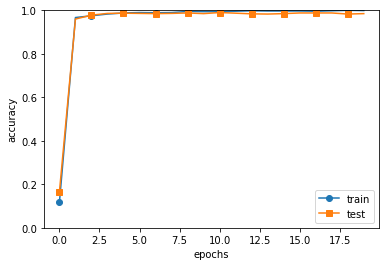

In [13]:
from source.dataset01.mnist import load_mnist
from source.common01.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("pickle/cnn_params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# CNNの可視化

以下は、1層目の可視化。学習前のフィルターはランダムに初期化されているが、学習を終えたフィルターは規則性がある。<br>
白から黒へグラデーションするフィルターや、塊のある領域（blob）を持つフィルターへ更新されている。<br>
これは、エッジに反応するフィルターへ更新されていることを示す。

========== 学習前 ==========


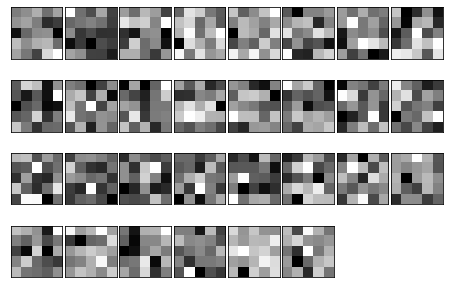

========== 学習後 ==========


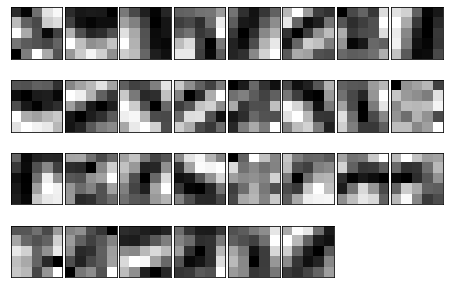

In [15]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
print("========== 学習前 ==========")
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("pickle/cnn_params.pkl")
print("========== 学習後 ==========")
filter_show(network.params['W1'])

CNNでは、層が深くなるに従って抽出される情報はより抽象化されていく。<br>
例えば、最初の層は単純なエッジに反応し、続いてテクスチャに反応し、そしてより複雑な物体のパーツに反応するようになるといった具合。

# 代表的なCNN

## LeNet

![](image/08_LeNet.png)
引用：LeCun, Yann, et al. "Object recognition with gradient-based learning." Shape, contour and grouping in computer vision. Springer, Berlin, Heidelberg, 1999. 319-345.

1998年に提案された、手書き数字を認識するネットワークで、初めてのCNN。<br>
現在主流のCNNとは異なり、活性化関数はReLUではなくSigmoid、Maxプーリングではなくsubsamplingによる中間データサイズ縮小が行われている。

## AlexNet

LeNetと異なる点は以下。
- 活性化関数がReLU
- LRN（Local Response Normalization）という局所的正規化を用いる
- Dropoutを使用する



LeNetから約20年の間、ビッグデータ入手が容易になったことや、大量並列計算を得意とするGPUの普及など、コンピュータ技術に大きな進歩があった。
AlexNetの基本構造はLeNetと大きくは変わらないが、ディープラーニングの発展の大きな原動力になった。